In [1]:
import os
import shutil
import random
from pathlib import Path
from sklearn.model_selection import train_test_split

# === Paths ===
SOURCE = Path("/kaggle/input/breast-histopathology-images")
WORKING = Path("/kaggle/working/data")

# Target folders
TRAIN = WORKING / "train"
VAL = WORKING / "val"
TEST = WORKING / "test"

# Make dirs
for split in [TRAIN, VAL, TEST]:
    for cls in ["cancer", "no_cancer"]:
        (split / cls).mkdir(parents=True, exist_ok=True)

# === Collect image paths ===
cancer_images = []
no_cancer_images = []

for patient_dir in SOURCE.glob("*"):
    for class_dir in patient_dir.glob("*"):
        label = class_dir.name
        for img_path in class_dir.glob("*.png"):
            if label == "1":
                cancer_images.append(str(img_path))
            else:
                no_cancer_images.append(str(img_path))

print(f"Total Cancer images: {len(cancer_images)}")
print(f"Total No Cancer images: {len(no_cancer_images)}")

# === Sample 50k each ===
cancer_images = random.sample(cancer_images, 50000)
no_cancer_images = random.sample(no_cancer_images, 50000)

# === Train/Val/Test split (70/15/15) ===
def split_and_copy(img_list, cls_name):
    train, temp = train_test_split(img_list, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    
    for img in train:
        shutil.copy(img, TRAIN / cls_name / os.path.basename(img))
    for img in val:
        shutil.copy(img, VAL / cls_name / os.path.basename(img))
    for img in test:
        shutil.copy(img, TEST / cls_name / os.path.basename(img))

split_and_copy(cancer_images, "cancer")
split_and_copy(no_cancer_images, "no_cancer")

print("✅ Dataset prepared with 100k images (50k each).")
print("   Train / Val / Test split done.")


Total Cancer images: 78786
Total No Cancer images: 198738
✅ Dataset prepared with 100k images (50k each).
   Train / Val / Test split done.


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

# === Paths ===
BASE_DIR = "/kaggle/working/data"
train_dir = os.path.join(BASE_DIR, "train")
val_dir = os.path.join(BASE_DIR, "val")
test_dir = os.path.join(BASE_DIR, "test")

# === Data Generators ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary"
)
val_gen = val_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary"
)
test_gen = val_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False
)

# === Model (VGG16) ===
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# === Callbacks ===
checkpoint = ModelCheckpoint("vgg16_idc.h5", monitor="val_accuracy",
                             save_best_only=True, mode="max", verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# === Train ===
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stop]
)

# === Evaluate ===
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc:.4f}")

# Save training history
import pandas as pd
pd.DataFrame(history.history).to_csv("training_history.csv", index=False)


2025-09-10 09:35:12.659866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757496912.854768      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757496912.912562      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 70000 images belonging to 2 classes.
Found 15000 images belonging to 2 classes.
Found 15000 images belonging to 2 classes.


I0000 00:00:1757496927.081931      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1757496936.156612      80 service.cc:148] XLA service 0x7a4b2400e030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757496936.157581      80 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757496936.589673      80 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1094 ━━━━━━━━━━━━━━━━━━━━ 5:30:26 18s/step - accuracy: 0.5000 - loss: 0.8864

I0000 00:00:1757496951.399870      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.6698 - loss: 0.6049
Epoch 1: val_accuracy improved from -inf to 0.77633, saving model to vgg16_idc.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 812s 726ms/step - accuracy: 0.6699 - loss: 0.6049 - val_accuracy: 0.7763 - val_loss: 0.4989
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.7784 - loss: 0.4877
Epoch 2: val_accuracy improved from 0.77633 to 0.78667, saving model to vgg16_idc.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 766s 700ms/step - accuracy: 0.7784 - loss: 0.4877 - val_accuracy: 0.7867 - val_loss: 0.4792
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.7893 - loss: 0.4718
Epoch 3: val_accuracy improved from 0.78667 to 0.79133, saving model to vgg16_idc.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 763s 697ms/step - accuracy: 0.7893 - loss: 0.4718 - val_accuracy: 0.7913 - val_loss: 0.4721
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.7951 - loss: 0.4647
Epoch 4: val_accuracy improved

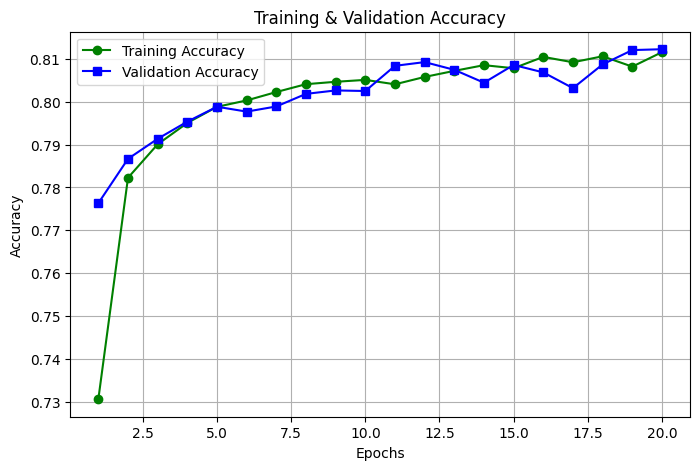

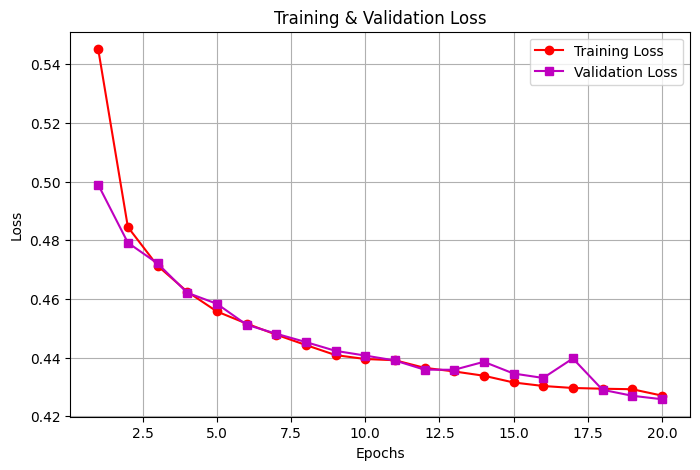

<Figure size 640x480 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc, 'g-o', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b-s', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'r-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'm-s', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_training_curves(history)
plt.savefig("accuracy_plot.png")
plt.savefig("loss_plot.png")
